## **Домашняя работа к Уроку 8**
## **Студент: Абрамов А.В.**

**Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети**

Импортируем необходимые зависимости

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Закачиваем датасет. В качестве датасета будем использовать набор картинок 5 видов цветов. Всего 3670 изображений

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [4]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 3670


Создаем датасеты и кэшируем их

In [5]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Для данной задачи классификации цветов будем применять нейронную сеть с последовательной архитектурой, состоящая из 3-х сверточных блоков (16-32-64) с максимальным объединяющим слоем в каждом из них, и с полносвязным слоем на 128 входов. Активационная функция - relu

Создаем модель, компилируем её и выводим summary

In [6]:
# create model
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Обучаем нейросеть и выводим графики точности


Epoch 1/10
92/92 [==============================] - 19s 38ms/step - loss: 1.2810 - accuracy: 0.4510 - val_loss: 1.1168 - val_accuracy: 0.5272
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0013 - accuracy: 0.5988 - val_loss: 0.9873 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8113 - accuracy: 0.6897 - val_loss: 1.0706 - val_accuracy: 0.5586
Epoch 4/10
92/92 [==============================] - 2s 22ms/step - loss: 0.6570 - accuracy: 0.7493 - val_loss: 0.8797 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.4339 - accuracy: 0.8426 - val_loss: 0.9137 - val_accuracy: 0.6730
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2572 - accuracy: 0.9097 - val_loss: 1.3441 - val_accuracy: 0.6117
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1779 - accuracy: 0.9418 - val_loss: 1.1387 - val_accuracy: 0.6526
Epoch 8/10
9

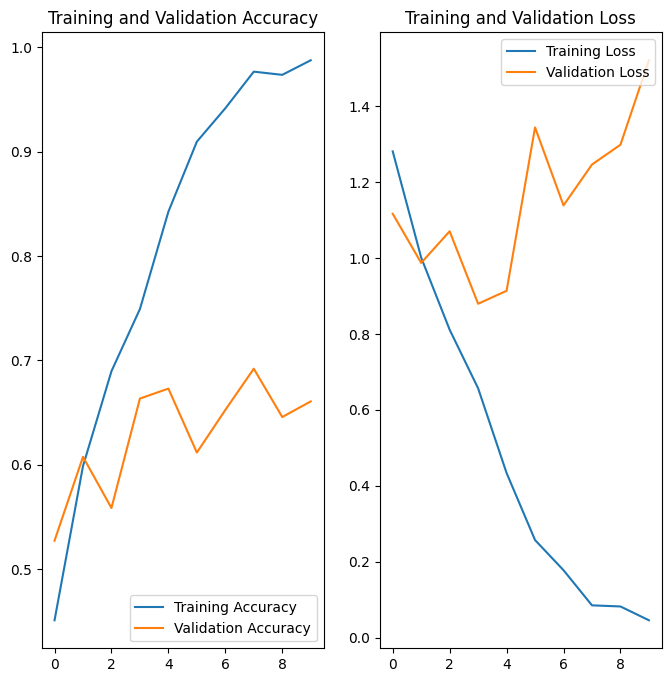

In [7]:
# train the model
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Видно, что на валидационной выборке по мере прохождения эпох возрастает ошибка. **Это переобучение!** Попробуем решить эту проблему, добавив аугментацию (горизонтал. отзеркаливание, поворот, зум, контрастирование) и регуляризацию (Dropout). Также увеличим кол-во эпох в 2 раза

In [8]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох

Epoch 1/20
92/92 [==============================] - 5s 32ms/step - loss: 1.3879 - accuracy: 0.4203 - val_loss: 1.0706 - val_accuracy: 0.5899
Epoch 2/20
92/92 [==============================] - 3s 30ms/step - loss: 1.0843 - accuracy: 0.5589 - val_loss: 1.0775 - val_accuracy: 0.5640
Epoch 3/20
92/92 [==============================] - 3s 30ms/step - loss: 0.9912 - accuracy: 0.6049 - val_loss: 0.9242 - val_accuracy: 0.6322
Epoch 4/20
92/92 [==============================] - 3s 30ms/step - loss: 0.9301 - accuracy: 0.6335 - val_loss: 0.9266 - val_accuracy: 0.6294
Epoch 5/20
92/92 [==============================] - 3s 32ms/step - loss: 0.8733 - accuracy: 0.6567 - val_loss: 0.8406 - val_accuracy: 0.6621
Epoch 6/20
92/92 [==============================] - 3s 30ms/step - loss: 0.8274 - accuracy: 0.6792 - val_loss: 0.8358 - val_accuracy: 0.6839
Epoch 7/20
92/92 [==============================] - 3s 30ms/step - loss: 0.7917 - accuracy: 0.6955 - val_loss: 0.7962 - val_accuracy: 0.6894
Epoch 8/20
92

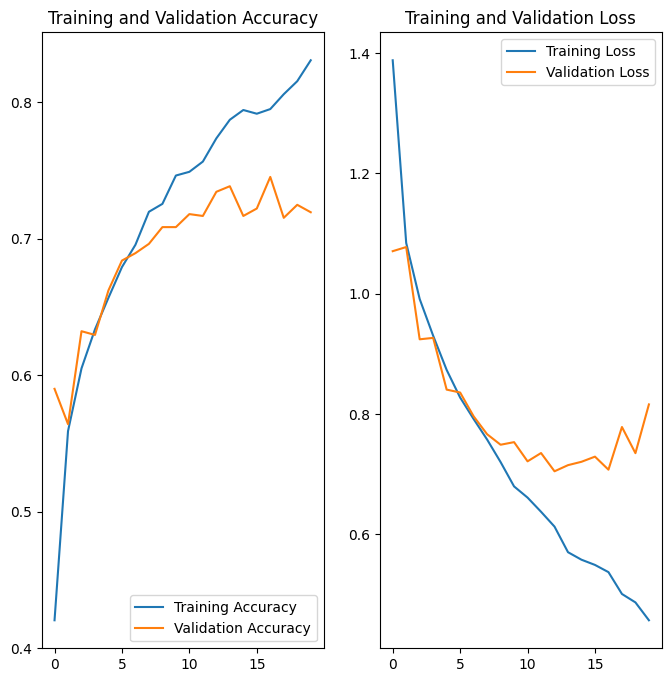

In [9]:
# train the model
epochs = 20 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Как видим, предпринятые меры снизили ошибку и повысили точность на валидационной выборке

Попробуем пропустить через сеть новое изображение (возьмем подсолнух)

In [13]:
# load image
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
img.show()

1/1 [==============================] - 0s 20ms/step
На изображении скорее всего sunflowers (64.84% вероятность)


Сеть справилась (64.84% вероятность на правильном классе)